In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, dataloader

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# GPU 하나
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('./chap05/data',download=False, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./chap05/data',download=False, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

In [5]:
len(train_dataset)

60000

In [7]:
train_dataset[2][0].size()

torch.Size([1, 28, 28])

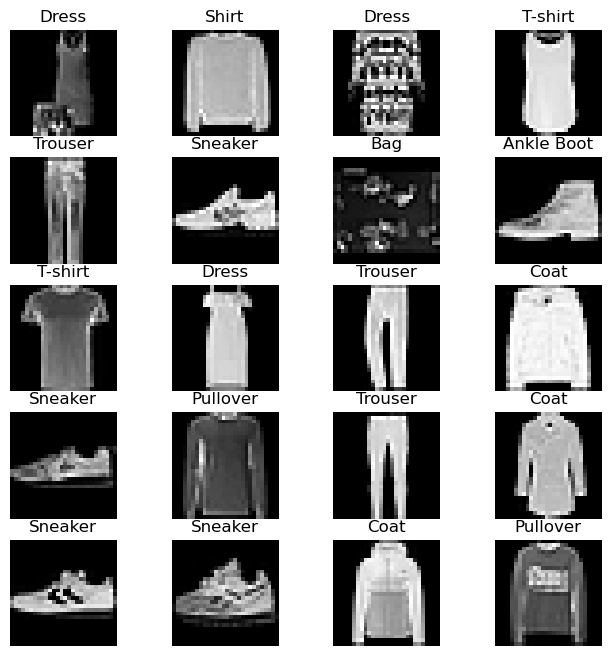

In [8]:
labels_map = {0:'T-shirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns =4
rows= 5
for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows,columns,i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

In [9]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)
    
    def forward(self,x):
        x = x.view(-1,784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [10]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
num_epoch= 5
count =0
loss_list = []
iteration_list=[]
accuracy_list=[]
predictions_list=[]
labels_list=[]

for epoch in range(num_epoch):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        outputs = model(train)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not( count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct *100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print('Iteration: {}, Loss:{}, Accuracy: {}%'.format(count,loss.data,accuracy))
        

        

Iteration: 500, Loss:0.5702499151229858, Accuracy: 83.13999938964844%
Iteration: 1000, Loss:0.4688129723072052, Accuracy: 85.23999786376953%
Iteration: 1500, Loss:0.3311654329299927, Accuracy: 84.02999877929688%
Iteration: 2000, Loss:0.40149539709091187, Accuracy: 85.04000091552734%
Iteration: 2500, Loss:0.28041723370552063, Accuracy: 86.0199966430664%
Iteration: 3000, Loss:0.3151101768016815, Accuracy: 86.30999755859375%


In [12]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1), #28 -> 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)    # 28 ->14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,3), #14 -> 12
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) # 12 -> 6
        )
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600,120)
        self.fc3 = nn.Linear(120,10)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x) # 100 * (64,6,6)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [13]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
batch_iter = iter(train_loader)
images, labels = next(batch_iter)
images, labels = images.to(device), labels.to(device)
test = Variable(images.view(100,1,28,28))
outputs = model(test)

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [15]:
outputs.size()

torch.Size([100, 10])

In [16]:
torch.max(outputs,1)[0].size()

torch.Size([100])

In [17]:
num_epochs = 5
count =0
loss_list = []
iteration_list =[]
accuracy_list =[]
predictions_list = []
labels_list = []

for epoch in range(num_epoch):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test) # torch.Size([100, 10])
                predictions = torch.max(outputs,1)[1].to(device) #(values(batch_size) 100개, indices(class으로 해석가능))
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count,loss.data,accuracy))


Iteration: 500, Loss: 0.5037537217140198, Accuracy: 87.15999603271484%
Iteration: 1000, Loss: 0.3270456790924072, Accuracy: 88.93000030517578%
Iteration: 1500, Loss: 0.25590115785598755, Accuracy: 88.8699951171875%
Iteration: 2000, Loss: 0.21195481717586517, Accuracy: 89.48999786376953%
Iteration: 2500, Loss: 0.1530134230852127, Accuracy: 88.93999481201172%
Iteration: 3000, Loss: 0.14456626772880554, Accuracy: 90.44999694824219%
